In [1]:
# run this cell for custom formating of notebook cells
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

This notebook presents a machine learning approach to predicting impact metrics of posts announced in the Facebook pages of a brand
For the sake of reproducibility, this kernel was writen using the following environmental set up

* Python        3.5.2
* Cython        0.24.1
* Numpy         1.14.2
* Pandas        0.20.3
* Scikit Learn  0.14.1
* Scipy         1.0.1
* Seaborn       0.8.1

### Introduction

Organizations have realized the benefits of social networks in influencing their customers. social media marketing strategies are now common place in business. Measuring the impact of advertisement is an important issue to be
included in a global social media strategy. A system that could predict the impact of each of their advertising posts would provide a valuable advantage when deciding to communicate through social media, helping to promote products and services, thus supporting brand building and there are no studies supporting the direct relation between post form and performance.

For this research, the dataset is that of a worldwide cosmetic company with a renowned brand. which includes 500 posts published by this company in the year of 2014 in the Facebook social network.
The objective of this work is to select a model that predicts the impact of posts using their characteristics.

After generating the model for a given performance metric, the results will be evaluated by comparing the real values for that metric with the value predicted by the model. A good model implies that it fits all the input data in a way that the predicted values are as close as possible to the real values

### Import Libraries

In [2]:
import numpy as np
from numpy import arange

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

import pandas as pd
from pandas import set_option

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error,r2_score, median_absolute_error

### Load The Dataset

In [3]:
facebook = pd.read_csv('data\dataset_Facebook.csv', sep=';')

### Data Exploration and Analysis

#### Shape

In [4]:
facebook.shape

(500, 19)

#### Info

In [5]:
facebook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

#### Head

In [6]:
facebook.head(5)

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


Of the 20 features of this dataset, only the first 7 are the predictors. The rest are the performance matrics we aim to predict. we will only be predicting a subset of this target features. By observation, all of the metrics are continuous valeues which makes this a regression problem. Most of the predictors are encoded as numerical figures but i suspect that they might be categorical but were encoded as numerical for easy rendering. I will investigate the class distribution of suspect features and encode them as required for machine learning.

#### Checking class distributions

In [7]:
# Type
facebook.Type.value_counts()

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [9]:
# Category
facebook.Category.value_counts()

1    215
3    155
2    130
Name: Category, dtype: int64

#### Seperating predictors and targets

In [10]:
features = facebook.iloc[:,:7]
targets = facebook.iloc[:,8:]

#### Descriptive stats

In [11]:
set_option('precision', 1)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Page total likes,500.0,123194.2,16272.8,81370.0,112676.0,129600.0,136393.0,139441.0
Category,500.0,1.9,0.9,1.0,1.0,2.0,3.0,3.0
Post Month,500.0,7.0,3.3,1.0,4.0,7.0,10.0,12.0
Post Weekday,500.0,4.2,2.0,1.0,2.0,4.0,6.0,7.0
Post Hour,500.0,7.8,4.4,1.0,3.0,9.0,11.0,23.0
Paid,499.0,0.3,0.4,0.0,0.0,0.0,1.0,1.0


In [12]:
targets.describe().T

,count,mean,std,min,25%,50%,75%,max
Lifetime Post Total Impressions,500.0,29585.9,76803.2,570.0,5694.8,9051.0,22085.5,1.1e+06
Lifetime Engaged Users,500.0,920.3,985.0,9.0,393.8,625.5,1062.0,1.1e+04
Lifetime Post Consumers,500.0,798.8,882.5,9.0,332.5,551.5,955.5,1.1e+04
Lifetime Post Consumptions,500.0,1415.1,2000.6,9.0,509.2,851.0,1463.0,2.0e+04
Lifetime Post Impressions by people who have liked your Page,500.0,16766.4,59791.0,567.0,3969.8,6255.5,14860.5,1.1e+06
Lifetime Post reach by people who like your Page,500.0,6585.5,7682.0,236.0,2181.5,3417.0,7989.0,5.1e+04
Lifetime People who have liked your Page and engaged with your post,500.0,610.0,612.7,9.0,291.0,412.0,656.2,4.4e+03
comment,500.0,7.5,21.2,0.0,1.0,3.0,7.0,3.7e+02
like,499.0,177.9,323.4,0.0,56.5,101.0,187.5,5.2e+03
share,496.0,27.3,42.6,0.0,10.0,19.0,32.2,7.9e+02


#### Kernel Density Estimates

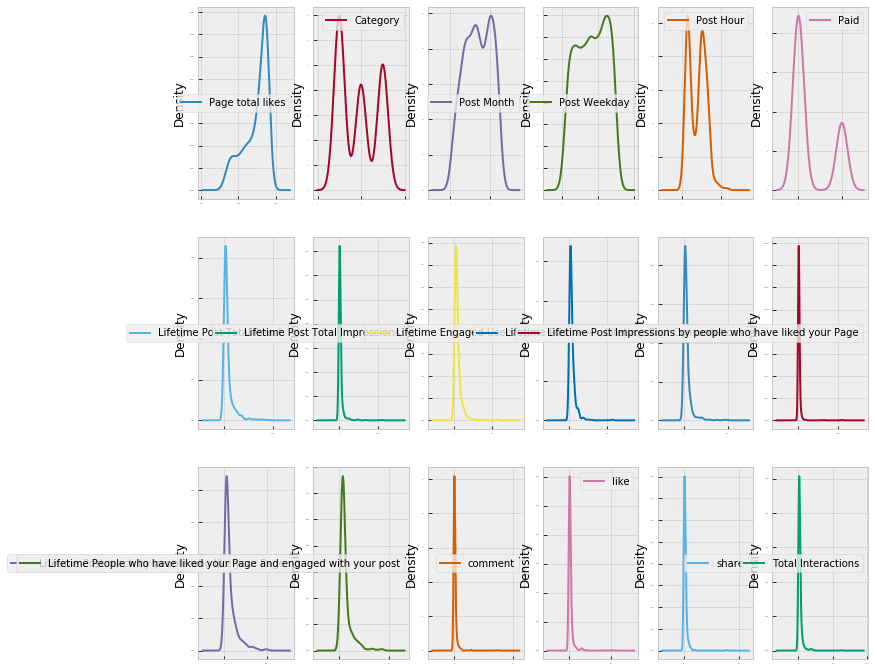

In [13]:
KDEs = facebook.plot(kind='density', subplots=True, layout=(3,6), sharex=False, legend=True, fontsize=1, figsize =(12,12))

#### Boxplots

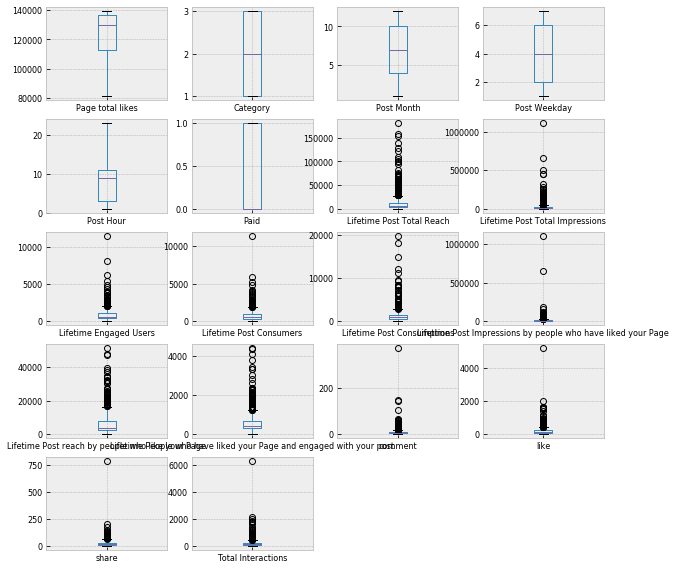

In [16]:
boxplots = facebook.plot(kind='box', subplots =True, layout=(5,4), sharex=False, sharey=False, fontsize=8, figsize=(10,10))

We see a clear lack of symmetry and presence of outliers in the distributions of most features. The candidate machine learning models might require normalization to be able to get good results. 

#### Probability plots

I want to find out if some features follow the normal distribution. for this i will use the normal probability plot function available in scipy

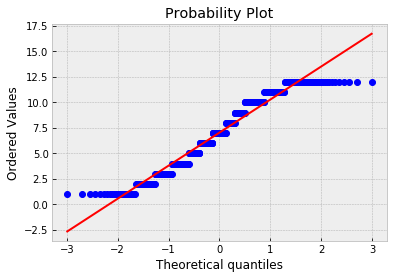

In [14]:
import scipy.stats as stats
probplot1=stats.probplot(features['Post Month'].values, dist='norm', plot=plt)

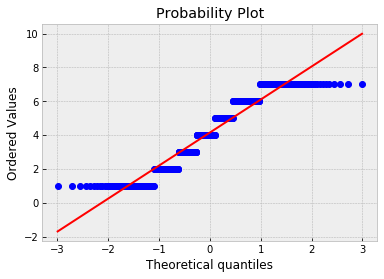

In [15]:
probplot2 = stats.probplot(features['Post Weekday'].values, dist='norm', plot=plt)

We see strong deviation from the normal distribution in both

#### Correlation matrix

[Text(0,0,'Page total likes'),
 Text(0,0,'Type'),
 Text(0,0,'Category'),
 Text(0,0,'Post Month'),
 Text(0,0,'Post Weekday'),
 Text(0,0,'Post Hour')]

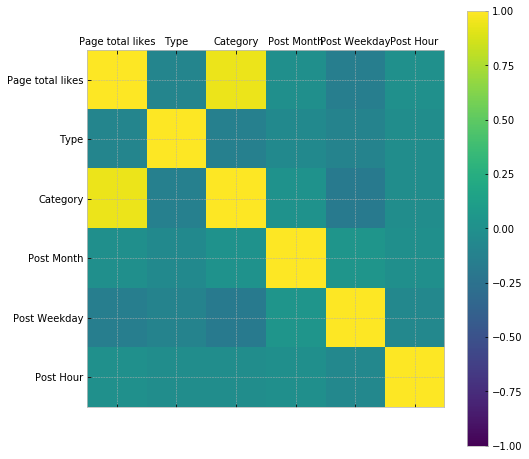

In [16]:
# correlation matrix 
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(features.corr(), vmin=-1,vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features.columns)
ax.set_yticklabels(features.columns)


There is strong correlation between page total likes and Category. I want to avoid multicollinearity problems that means i might have to drop one of them. but i will plot a scatter plot to further investigate the problem and perhaps come up with clues for a solution

Text(0,0.5,'Page total likes')

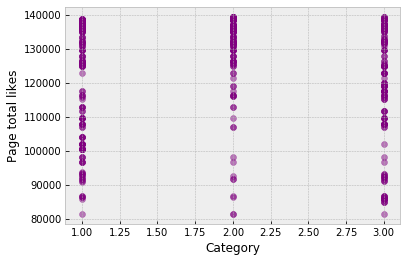

In [17]:
plt.scatter(features.iloc[:,2], features.iloc[:,0],alpha=0.5,c='purple')
plt.xlabel('Category')
plt.ylabel('Page total likes')

As observed earlier, Category is a nominal feature so its better that i encode and handle it as such

### Preprocessing

#### Type casting

In [18]:
features['Category'] = features['Category'].astype('object')

#### Transformation

In [19]:
features.iloc[:,[0,3,4,5]] = np.log(features.iloc[:,[0,3,4,5]].values+1)

In [24]:
targets.iloc[:,:] = np.log(targets.values+1)

#### Handling missing values

In [20]:
features['Paid'].fillna(1, inplace=True)

#### Dummy encoding

In [21]:
features_dummies = pd.get_dummies(features)

#### Sanity Checks

In [22]:
# Column names
features_dummies.head()

,Page total likes,Post Month,Post Weekday,Post Hour,Paid,Type_Link,Type_Photo,Type_Status,Type_Video,Category_1,Category_2,Category_3
0,11.8,2.6,1.6,1.4,0.0,0,1,0,0,0,1,0
1,11.8,2.6,1.4,2.4,0.0,0,0,1,0,0,1,0
2,11.8,2.6,1.4,1.4,0.0,0,1,0,0,0,0,1
3,11.8,2.6,1.1,2.4,1.0,0,1,0,0,0,1,0
4,11.8,2.6,1.1,1.4,0.0,0,1,0,0,0,1,0


In [23]:
# Unique values
features_dummies['Paid'].unique()

array([ 0.,  1.])

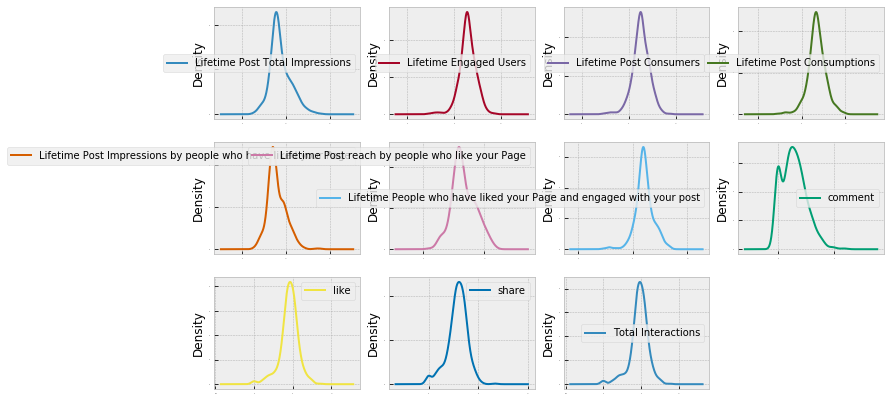

In [25]:
# New distributions
KDEs = targets.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize =(12,12))

All looks good now except the target feature names are too lengthy to fit into the screen. We will have to rename them for brevity and select only the subset that matches our objective.

In [26]:
# Column names
targets.columns

Index(['Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

#### Selecting subset of interest

In [27]:
target_sub = targets.iloc[:,[3,6,8,9]]

In [28]:
target_sub.columns

Index(['Lifetime Post Consumptions',
       'Lifetime People who have liked your Page and engaged with your post',
       'like', 'share'],
      dtype='object')

#### Renaming features

In [29]:
target_sub = target_sub.rename(columns={'Lifetime People who have liked your Page and engaged with your post':'like_engaged','Lifetime Post Consumptions':'Consumptions'})

#### New column names

In [30]:
target_sub.columns

Index(['Consumptions', 'like_engaged', 'like', 'share'], dtype='object')

#### Creating individual Series of target variables

In [31]:
consumptions = target_sub['Consumptions']
liked_engaged = target_sub['like_engaged']
likes = target_sub['like']
shares = target_sub['share']

#### Handling missing values

In [32]:
likes.fillna(likes.mean(), inplace=True)
shares.fillna(shares.mean(), inplace=True)

All is set. We caan now start building models and testing their parfomances

### Building Models

In [ ]:
We will select the best model that best predicts each of the target variable seperately

#### Predicting lifetime post consumptions

#### Train test split

In [33]:
test_size = 0.2
seed = 0
data_train, data_validation, consumptions_train, consumptions_validation = train_test_split(features_dummies, consumptions, test_size=test_size,random_state=seed)


#### Building pipelines for scaling and model instantiation

Since the data contains many outliers, scaling using the mean and variance of the data is likely to not work very well.
Therefore, we can use RobustScaler as drop-in replacements instead. They use more robust estimates for the center and range of your data.

In [34]:
pipelines =[]
pipelines.append(('ScaledLR', Pipeline([('Scaler', RobustScaler()),('LR', LinearRegression())])))
pipelines.append(('ScalerLasso', Pipeline([('Scaler', RobustScaler()),('LASSO', Lasso())])))
pipelines.append(('ScalarEN', Pipeline([('Scaler',RobustScaler()),('EN',ElasticNet())])))
pipelines.append(('ScalerKNN', Pipeline([('Scaler', RobustScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScalerCART', Pipeline([('Scaler', RobustScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScalerSVR', Pipeline([('Scaler', RobustScaler()),('SVR', SVR())])))
pipelines.append(('ScalerRansac', Pipeline([('Scaler', RobustScaler()),('RANSAC', RANSACRegressor())])))


#### Evaluate Algorithms

We will use 10-fold cross validation and will evaluate algorithms using the Median absolute Error (MAE) metric because it is a robust metric against outliers. MAE will give a gross idea of how wrong all predictions are (0 is perfect). The algorithms all use default tuning parameters. Let's compare the algorithms. We will display the mean and standard deviation of MSE for each algorithm as we calculate it and collect the results for use later.

In [35]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, data_train, consumptions_train, cv=kfold, scoring='neg_median_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('{0}: {1:.4f} ({2:.4f})'.format(name, cv_results.mean(), cv_results.std()))

ScaledLR: -0.3985 (0.1004)
ScalerLasso: -0.6084 (0.1636)
ScalarEN: -0.6084 (0.1636)
ScalerKNN: -0.4506 (0.1167)
ScalerCART: -0.5008 (0.0902)
ScalerSVR: -0.3918 (0.0801)
ScalerRansac: -0.4507 (0.0543)


Let's take a look at the distribution of scores across all cross validation folds by algorithm.

[Text(0,0,'ScaledLR'),
 Text(0,0,'ScalerLasso'),
 Text(0,0,'ScalarEN'),
 Text(0,0,'ScalerKNN'),
 Text(0,0,'ScalerCART'),
 Text(0,0,'ScalerSVR'),
 Text(0,0,'ScalerRansac')]

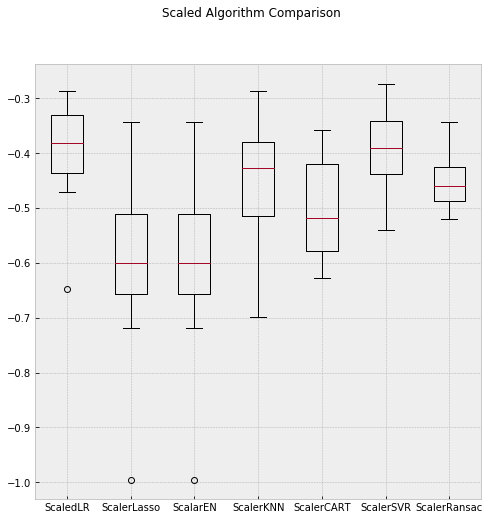

In [36]:
# Compare Algorithms
fig = plt.figure(figsize=(8,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

It seems SVR is the best model for predicting life time post consumption.  We will display the performance of SVR using different metrics. A problem in accepting the result of this modelling is that the values have all been transformed into logarithm scale, therefore, the small error values observed may not be telling the whole truth about performance of the models. A performance metric that captures percentage errors (such as Mean absolute percentage error) instead of absolute values is needed to get a clearer picture. Unfortunately, such metric isnt implemented in scikit learn, so we would have to define it ourselves.

#### Defining Mean Absolute Percentage Error (MAPE)

In [37]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100
# The problem with this code and possibly why scikit learn doesnt implement is due to the likelihood of raising ZeroDivisionError
# lets just hope we are safe in our application

In [38]:
from sklearn.metrics import mean_absolute_error

In [41]:
scaler = RobustScaler().fit(data_train)
rescaledX = scaler.transform(data_train)
consumption_model = SVR()
consumption_model.fit(rescaledX, consumptions_train)
rescaledValidationX = scaler.transform(data_validation)
predictions =consumption_model.predict(rescaledValidationX)
print('Mean absolute error:\n', mean_absolute_error(consumptions_validation, predictions))
print()
print('Median absolute error:\n', median_absolute_error(consumptions_validation, predictions))
print()
print('Mean absolute  percentage error:\n', mean_absolute_percentage_error(consumptions_validation, predictions))

Mean absolute error:
 0.549749586001

Median absolute error:
 0.36567686384

Mean absolute  percentage error:
 9.67171589648


In [ ]:
Wow!!! With only 9.6% error, our model is perfect for predicting life time post consumption. We can go ahead to save it

#### Saving life time post consumption model

In [42]:
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
# save the model to disk
filename = 'models\post_consumption_model.sav'
dump(consumption_model, filename)

['post_consumption_model.sav']

#### Predicting Lifetime People who have liked your Page and engaged with your post

#### Train test split

In [43]:
test_size = 0.2
seed = 0
data_train, data_validation, liked_engaged_train, liked_engagaed_validation = train_test_split(features_dummies, liked_engaged, test_size=test_size,random_state=seed)


#### Evaluate Algorithms

In [44]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, data_train, liked_engaged_train, cv=kfold, scoring='neg_median_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('{0}: {1:.4f} ({2:.4f})'.format(name, cv_results.mean(), cv_results.std()))

ScaledLR: -0.3257 (0.0443)
ScalerLasso: -0.4201 (0.1252)
ScalarEN: -0.4201 (0.1252)
ScalerKNN: -0.3739 (0.0733)
ScalerCART: -0.4461 (0.0531)
ScalerSVR: -0.3037 (0.0497)
ScalerRansac: -0.3259 (0.0514)


[Text(0,0,'ScaledLR'),
 Text(0,0,'ScalerLasso'),
 Text(0,0,'ScalarEN'),
 Text(0,0,'ScalerKNN'),
 Text(0,0,'ScalerCART'),
 Text(0,0,'ScalerSVR'),
 Text(0,0,'ScalerRansac')]

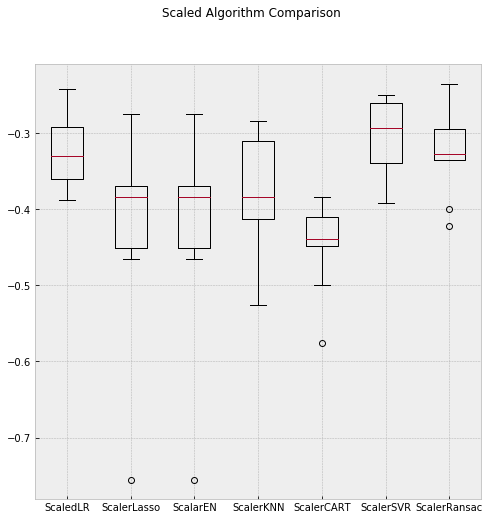

In [45]:
# Compare Algorithms
fig = plt.figure(figsize=(8,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

SVR is again the winner here. lets see its scores using other metrics on the validation set

In [46]:
scaler = RobustScaler().fit(data_train)
rescaledX = scaler.transform(data_train)
liked_engaged_model = SVR()
liked_engaged_model.fit(rescaledX, liked_engaged_train)
ValidationX = scaler.transform(data_validation)
predictions =liked_engaged_model.predict(ValidationX)
print('Mean absolute error:\n', mean_absolute_error(liked_engagaed_validation, predictions))
print()
print('Median absolute error:\n', median_absolute_error(liked_engagaed_validation, predictions))
print()
print('Mean absolute  percentage error:\n', mean_absolute_percentage_error(liked_engagaed_validation, predictions))

Mean absolute error:
 0.483000737243

Median absolute error:
 0.325836749898

Mean absolute  percentage error:
 9.26163837019


9.3% error. lovely! now lets save the model

In [48]:
# save the model to disk
filename = 'models\liked_engaged_model.sav'
dump(liked_engaged_model, filename)

['liked_engaged_model.sav']

#### Predicting Likes

In [49]:
test_size = 0.2
seed = 0
data_train, data_validation, likes_train, likes_validation = train_test_split(features_dummies, likes, test_size=test_size,random_state=seed)


In [50]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, data_train, likes_train, cv=kfold, scoring='neg_median_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('{0}: {1:.4f} ({2:.4f})'.format(name, cv_results.mean(), cv_results.std()))

ScaledLR: -0.5960 (0.0993)
ScalerLasso: -0.5836 (0.1060)
ScalarEN: -0.5836 (0.1060)
ScalerKNN: -0.6363 (0.1622)
ScalerCART: -0.8252 (0.1624)
ScalerSVR: -0.5968 (0.0811)
ScalerRansac: -0.6104 (0.1300)


[Text(0,0,'ScaledLR'),
 Text(0,0,'ScalerLasso'),
 Text(0,0,'ScalarEN'),
 Text(0,0,'ScalerKNN'),
 Text(0,0,'ScalerCART'),
 Text(0,0,'ScalerSVR'),
 Text(0,0,'ScalerRansac')]

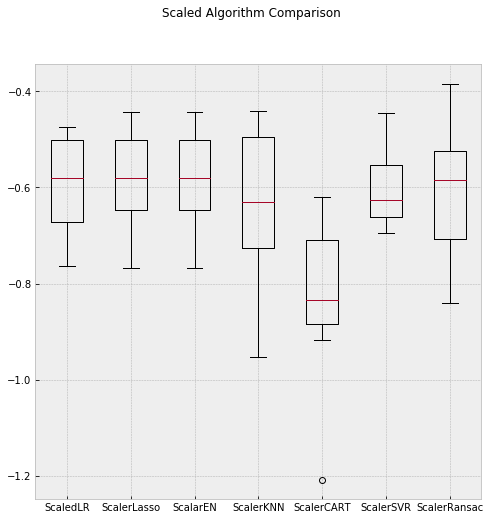

In [51]:
# Compare Algorithms
fig = plt.figure(figsize=(8,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

Lasso has broken SVRs winning streak. Though it has slightly higher absolute values compared to what we have seen so far. lets see its generalization performance

In [52]:
scaler = RobustScaler().fit(data_train)
rescaledX = scaler.transform(data_train)
likes_model = Lasso()
likes_model.fit(rescaledX, likes_train)
ValidationX = scaler.transform(data_validation)
predictions =likes_model.predict(ValidationX)
print('Mean absolute error:\n', mean_absolute_error(likes_validation, predictions))
print()
print('Median absolute error:\n', median_absolute_error(likes_validation, predictions))
print()
print('Mean absolute  percentage error:\n', mean_absolute_percentage_error(likes_validation, predictions))

Mean absolute error:
 0.888251976224

Median absolute error:
 0.578726394346

Mean absolute  percentage error:
 inf


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [ ]:
We see the divide by zero error being raised here when calculating MAPE. we will still go ahead to save the model

In [53]:
# save the model to disk
filename = 'models\likes_model.sav'
dump(likes_model, filename)

['likes_model.sav']

#### Predicting Shares

In [54]:
test_size = 0.2
seed = 0
data_train, data_validation, shares_train, shares_validation = train_test_split(features_dummies, shares, test_size=test_size,random_state=seed)


In [55]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, data_train, shares_train, cv=kfold, scoring='neg_median_absolute_error')
    results.append(cv_results)
    names.append(name)
    print('{0}: {1:.4f} ({2:.4f})'.format(name, cv_results.mean(), cv_results.std()))

ScaledLR: -0.5275 (0.0647)
ScalerLasso: -0.5566 (0.0777)
ScalarEN: -0.5566 (0.0777)
ScalerKNN: -0.5728 (0.1086)
ScalerCART: -0.7116 (0.1447)
ScalerSVR: -0.5236 (0.1046)
ScalerRansac: -0.5668 (0.0802)


[Text(0,0,'ScaledLR'),
 Text(0,0,'ScalerLasso'),
 Text(0,0,'ScalarEN'),
 Text(0,0,'ScalerKNN'),
 Text(0,0,'ScalerCART'),
 Text(0,0,'ScalerSVR'),
 Text(0,0,'ScalerRansac')]

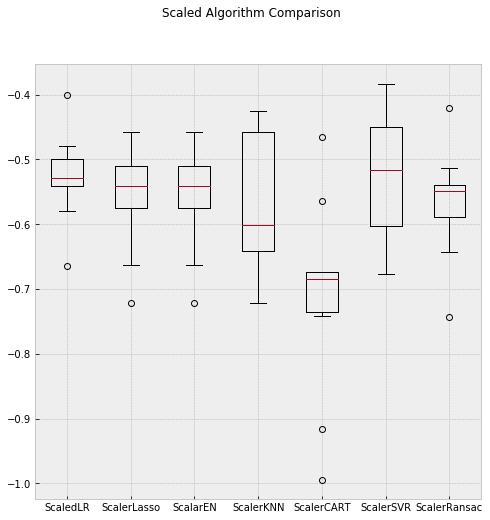

In [56]:
# Compare Algorithms
fig = plt.figure(figsize=(8,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

SVR has the lowest mean error values but i will go with the linear model here because of is lower variance

#### Genralization performance

In [57]:
scaler = RobustScaler().fit(data_train)
rescaledX = scaler.transform(data_train)
shares_model = LinearRegression()
shares_model.fit(rescaledX, shares_train)
ValidationX = scaler.transform(data_validation)
predictions =likes_model.predict(ValidationX)
print('Mean absolute error:\n', mean_absolute_error(shares_validation, predictions))
print()
print('Median absolute error:\n', median_absolute_error(shares_validation, predictions))
print()
print('Mean absolute  percentage error:\n', mean_absolute_percentage_error(shares_validation, predictions))

Mean absolute error:
 1.73539725193

Median absolute error:
 1.6672094982

Mean absolute  percentage error:
 inf


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [ ]:
Another divide by zero error raised but as before, the model looks good and safe to save.

In [58]:
# save the model to disk
filename = 'models\shares_model.sav'
dump(shares_model, filename)

['shares_model.sav']

### Summary and Outlook

This notebook presented  a machine learning method to predict the impact of performance metrics obtained from posts announced in the Facebook page of a phamaceutical company. The derived models were the best performers among various candidate regression models. The findings of this research can potentially help the managers in making the right decisions regarding whether to publish a post. For future research, more advanced data mining techniques should be considered and the work extended by analyzing feature importances of the various champion models in order to understand the key variables that drive each metric.